In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from deepsensor.data import DataProcessor, TaskLoader
from deepsensor.model import ConvNP
from deepsensor.train import Trainer
from deepsensor.train import set_gpu_default_device

# Import custom modules
from deepsensor_greatlakes.dataset_loader import (
    load_metadata, 
    load_glsea_data_combined, 
    load_context_data
)
from deepsensor_greatlakes.preprocessor import SeasonalCycleProcessor

In [2]:
# Load project metadata
metadata = load_metadata()

# Load context data
context_data = load_context_data(metadata)

# Load GLSEA data for specific years
glsea_ds = load_glsea_data_combined(metadata, years=[1995, 1996])


Loading context data:
Loading bathymetry

Bathymetry Validation:
Dimensions: 240 x 360
Depth range: 10.00m to 316.63m
Coverage: 23.0%
Loading lakemask

Lakemask Validation:
Dimensions: 838 x 1181
Values: [0. 1.]
Coverage: 100.0%
Loading glsea for 1995
Loading glsea for 1996

Combining GLSEA datasets...

GLSEA Data Validation:
Time range: 1995-01-01T00:00:00.000000000 to 1996-12-31T00:00:00.000000000
Spatial dimensions: 838 x 1181
SST range: 0.00°C to 29.49°C
Water coverage: 14.1%


In [3]:
# Calculate seasonal cycle
seasonal_processor = SeasonalCycleProcessor()
seasonal_processor.calculate(glsea_ds)
seasonal_processor.save("

# Compute anomalies
sst_anomalies = seasonal_processor.compute_anomalies(glsea_ds)

In [4]:
# Initialize DeepSensor DataProcessor
data_processor = DataProcessor(x1_name="lat", x2_name="lon")

# Normalize the anomalies
sst_normalized = data_processor(sst_anomalies)

# Normalize the anomalies
bathy_normalized, lakemask_normalized = data_processor([context_data['bathymetry'], context_data['lakemask']], method="min_max")

/home/jupyter/deepsensor-greatlakes/venv/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/jupyter/deepsensor-greatlakes/venv/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/jupyter/deepsensor-greatlakes/venv/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/jupyter/deepsensor-greatlakes/venv/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_rivers_lake_centerlines.zip
  warning

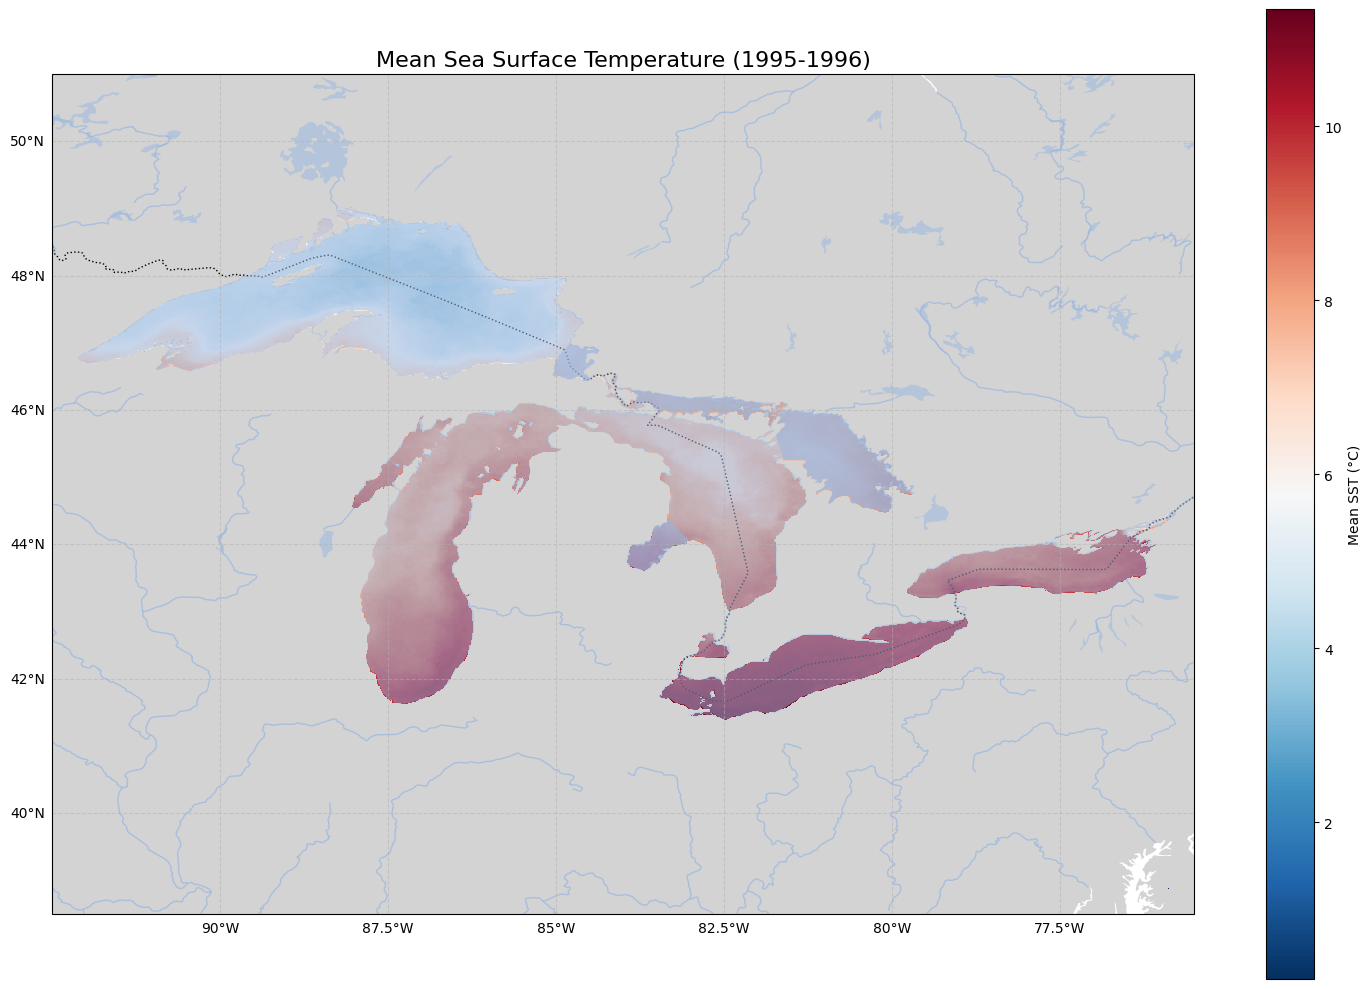

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Assuming 'sst' is the xarray.Dataset you provided
sst_mean = glsea_ds.mean(dim='time')  # Compute the mean SST over time

# Create figure and map projection
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgrey')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS, linestyle='-', alpha=0.7)

# Plot the mean SST directly from the xarray dataset
im = sst_mean.sst.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    add_colorbar=False,  # We'll add a custom colorbar later
)

# Add a colorbar
plt.colorbar(im, ax=ax, label='Mean SST (°C)')

# Set the map extent to focus on the Great Lakes region
ax.set_extent([-92.5, -75.5, 38.5, 51], crs=ccrs.PlateCarree())

# Add gridlines for better reference
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Add a title
plt.title('Mean Sea Surface Temperature (1995-1996)', fontsize=16)

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()


In [6]:
# Optional: Save processors and seasonal cycle
#seasonal_processor.save("data/seasonal_cycles/glsea_1995_1996")
#data_processor.save("data/processors/glsea_sst_anomalies")

# Print some basic information
print("Data preprocessing and visualization complete.")
print(f"Normalized SST Anomaly Shape: {sst_normalized.sst.shape}")

Data preprocessing and visualization complete.
Normalized SST Anomaly Shape: (731, 838, 1181)


In [7]:
# Set up DeepSensor task loader (for context and target variables)
task_loader = TaskLoader(
    context = [sst_normalized, bathy_normalized, lakemask_normalized], 
    target = sst_normalized,
)

In [8]:
# Initialize DeepSensor model
model = ConvNP(data_processor, task_loader)

dim_yc inferred from TaskLoader: (1, 1, 1)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 1180
encoder_scales inferred from TaskLoader: [np.float32(0.0004237288), np.float32(0.0009355429), np.float32(0.0004237288)]
decoder_scale inferred from TaskLoader: 0.000847457627118644


AttributeError: Attempting to access Backend.str before str has been assigned. Please assign a backend with `import deepsensor.tensorflow` or `import deepsensor.torch` before using backend-dependent functionality.

In [ ]:
# Prepare the training and validation sets
# You can define your own validation set based on time or other criteria
train_dates = pd.date_range('1995-01-01', '2015-12-31', freq='1D')
val_dates = pd.date_range('2016-01-01', '2017-12-31', freq='1D')

train_tasks = task_loader.generate_tasks(train_dates)
val_tasks = task_loader.generate_tasks(val_dates)